<a href="https://colab.research.google.com/github/eohta/udemy-numpyro-basic/blob/main/02_plants/02_compare_mean_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 【ポアソン分布の比較】野菜の収穫量

異なる肥料の効果をポアソン分布の母数を比較することで評価してみる。

## Package Installation

In [1]:
# !pip install numpyro

インストール完了後にランタイムを再スタートして下さい！

## Import Package

In [16]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [4]:
plt.rcParams['font.size'] = 12

## Load & Check Data

In [5]:
data = pd.DataFrame({
    
    'yield':[ 7, 13, 13, 11,  5,  6,  8, 11, 10, 11, 11, 11, 11, 14,  8, 15, 10,
        9, 13, 12,  8, 15,  7, 11,  5, 11, 15, 10, 13,  9,  8, 12, 13,  6,
        8,  5, 13,  8,  5, 10, 18,  9,  7, 12, 11,  5,  9, 10, 13, 13,  7,
       12,  8, 16, 10,  6, 12, 13, 10, 12,  9,  7, 12, 11,  8, 15, 13, 11,
        9, 17, 11, 10, 15, 19, 11, 13, 12,  9, 10, 10],
    
    'group':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
})

In [6]:
data.shape

(80, 2)

In [ ]:
data.head(20)

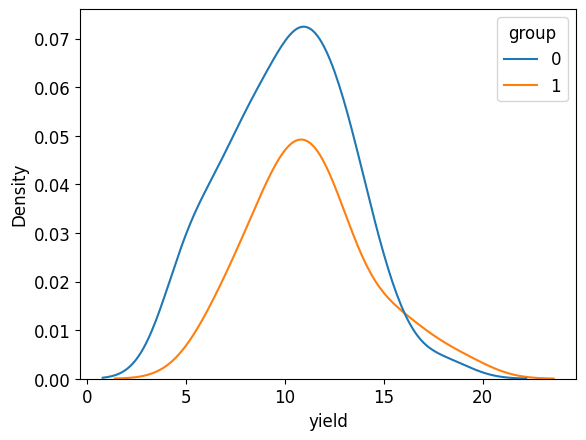

In [10]:
sns.kdeplot(data=data, x='yield', hue='group');

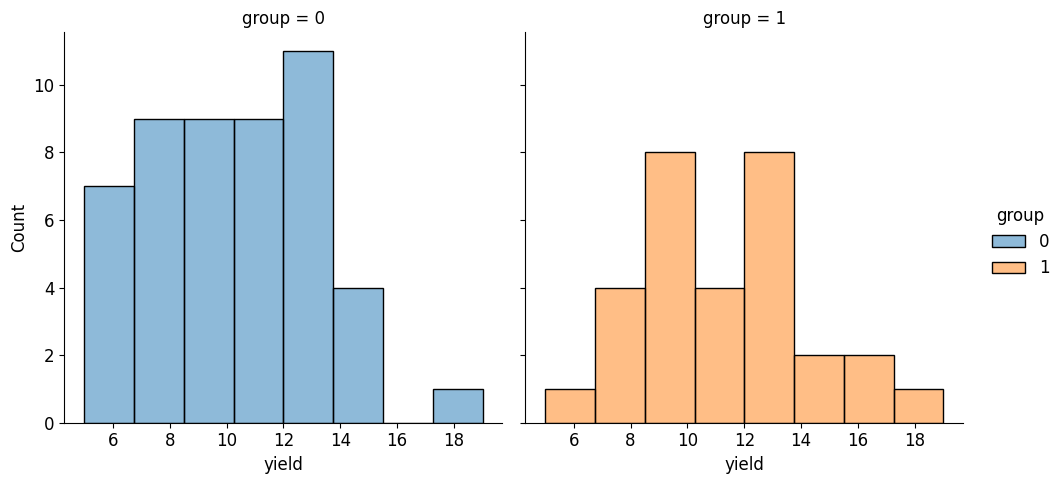

In [12]:
sns.displot(data=data, x='yield', hue='group', col='group',kind="hist");

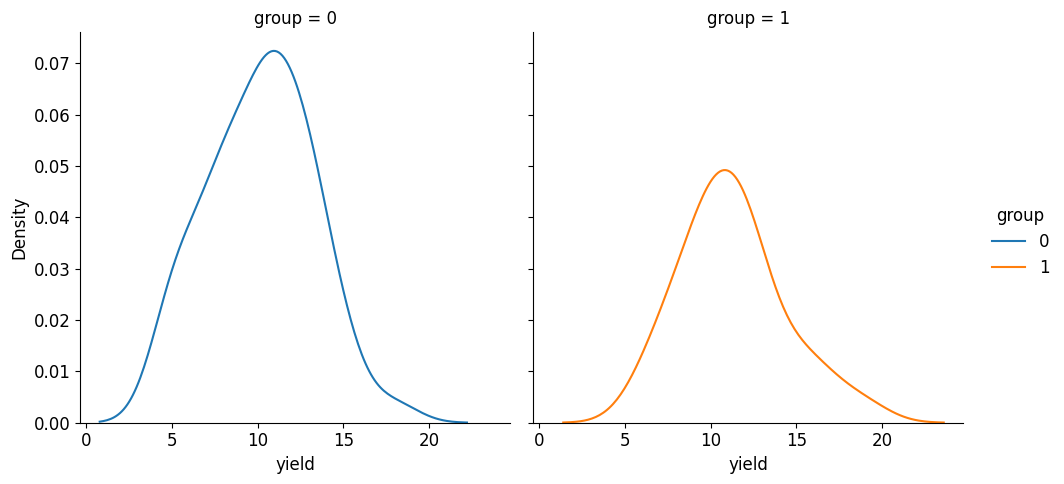

In [11]:
sns.displot(data=data, x='yield', hue='group', col='group',kind="kde");

In [13]:
data.groupby('group').mean()

,yield
group,
0,10.160000
1,11.266667


## Define Model & Inference

In [14]:
y = data['yield'].values
g = data['group'].values

In [ ]:
# This is a classic case of group comparison using latent variables.
# defined a hierarchical Bayesian model comparing two groups (0 and 1), each with independent Poisson means.


In [15]:
def model(y=None, g=None, num_data=0):

    # prior
    mu = numpyro.sample('mu', dist.HalfNormal(10), sample_shape=(2,))

    # mu is a length-2 vector:
    # μ=[μ0,μ1 ]∼HalfNormal(10)
    # representing the Poisson rate for group 0 and group 1, respectively.
    
    mu_per_group = mu[g]

    #likelihood
    
    with numpyro.plate('data', num_data):
    
        numpyro.sample('obs', dist.Poisson(mu_per_group), obs=y)

    # You define a deterministic variable mu_diff = difference between group means.
    mu_diff = numpyro.deterministic('mu_diff', mu[1] - mu[0])

In [17]:
nuts = NUTS(model)
mcmc = MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), y=y, g=g, num_data=len(y))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

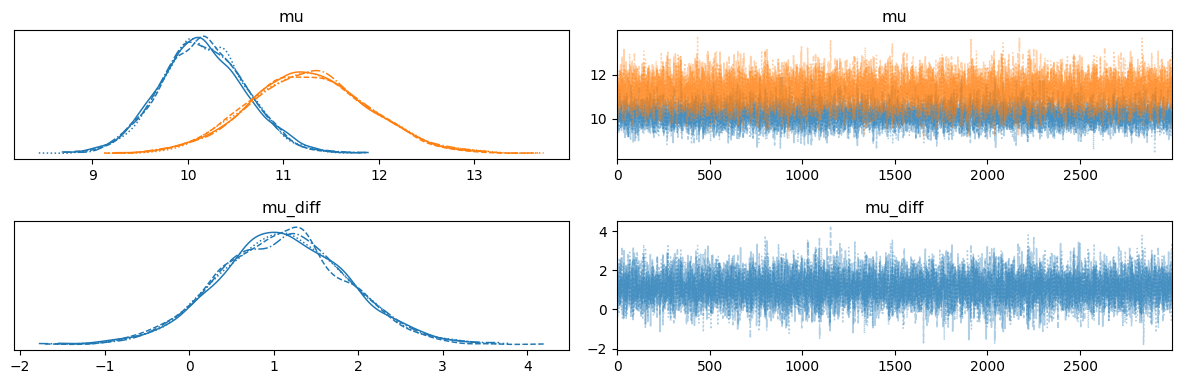

In [23]:
az.plot_trace(idata);
plt.tight_layout()
# plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

## Compare Parameters

In [ ]:
# 44.6% chance that mu_diff < 1
# → So about 55.4% of the posterior mass suggests group 1's mean is at least 1 unit higher than group 0. This is modest evidence in favor, but not overwhelming.

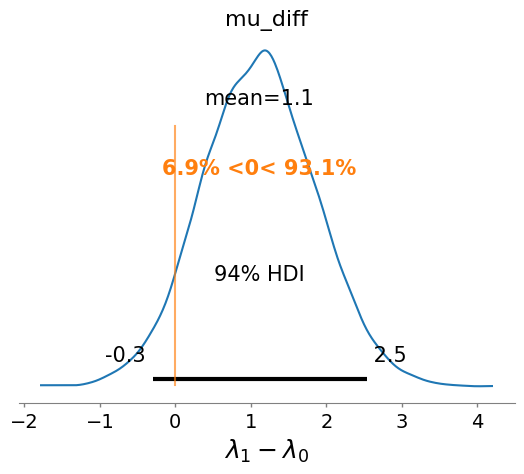

In [26]:
az.plot_posterior(idata, var_names=['mu_diff'], ref_val=0)

plt.xlabel('$\lambda_1 - \lambda_0$', fontsize=18);